# Machine Learning Introduction - Naive Bayes

Machine Learning deals only with numeric data
but not all data in the world is numeric.
Two examples of non-numerical data that is meaningful for learning about data are:
categorical features and plain text (e.g. product reviews).
There are tricks that allow us to deal with non-numerical data,
these tricks are part of *feature engineering*.

For a start let's import a handful of things.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Feature Engineering

Dealing with non-numerical data is only a part of feature engineering,
although is often the most common application that is called by this name.
Actually feature engineering is not a collection of techniques
but a generic name to define tasks performed around input data to our model.
These include:

- Modifying existing features - e.g. scaling
- Selecting only a subset of features - e.g. removing highly correlated features
- Building new features from existing ones - e.g. squaring features to get only positive values
- Encoding features in a different representation - e.g. one-hot-encoding
- Learning new features from data - e.g. huge neural networks fed with lots of data

The last example requires really huge amounts of data,
hundreds of millions of samples.

## Categorical Data

When we deal with the proper names of things or people we are most often dealing
with categorical data.  One example of such would be:

In [2]:
country = ["England", "Scotland", "Wales", "England", "England"]
city = ["Hull", "Glasgow", "Cardiff", "London", "Exeter"]
population2011 = np.array([284321, 598830, 335145, 8136000, 127300])
data = pd.DataFrame(
    {
        "country": country,
        "city": city,
        "population": population2011,
    }
)
data.country = data.country.astype("category")
data.city = data.city.astype("category")
data

,country,city,population
0,England,Hull,284321
1,Scotland,Glasgow,598830
2,Wales,Cardiff,335145
3,England,London,8136000
4,England,Exeter,127300


Note that we forced the country to have a categorical type.
In `pandas` that is a way of assigning numbers to a column,
these numbers then reference a set of categorical labels.

This also means that the data now is completely numerical.
i.e. we can do this:

In [3]:
pd.merge(
    pd.DataFrame(
        {
            "country": data.country.cat.codes,
            "city": data.city.cat.codes,
        }
    ),
    pd.DataFrame(data.population),
    left_index=True,
    right_index=True,
)

,country,city,population
0,0,3,284321
1,1,2,598830
2,2,0,335145
3,0,4,8136000
4,0,1,127300


Yet, that is *not* enough.
Numerical values have an order, therefore we can test for inequality.
Based on the data above we can say that:

$$\texttt{Scotland} < \texttt{Wales}$$

or

$$\texttt{Scotland} > \texttt{England}$$

Unfortunately, apart from their use in rugby jokes, these inequalities are rather useless.
Moreover these inequalities are likely to confuse an ML algorithm.
Instead we need to encode the data into a form called **one-hot-encoding**.
Each sample has several features built from the categorical feature
but only one of the columns contain a one, all other columns contain zeros.

`pandas`' `get_dummies` exists for this exact purpose,
to build a one-hot-encoding from a categorical feature.

In [4]:
pd.get_dummies(data, prefix_sep="=")

,population,country=England,country=Scotland,country=Wales,city=Cardiff,city=Exeter,city=Glasgow,city=Hull,city=London
0,284321,True,False,False,False,False,False,True,False
1,598830,False,True,False,False,False,True,False,False
2,335145,False,False,True,True,False,False,False,False
3,8136000,True,False,False,False,False,False,False,True
4,127300,True,False,False,False,True,False,False,False


And this is something that we can feed into an ML technique without worrying about confusing it.
That said, this representation can use huge amounts of memory if there is a big number of features.
To alleviate the memory problem `sklearn` can perform one-hot-encoding on sparse matrices (from `scipy`),
this way we only need to store the ones.

## Textual Data

Plain, unorganized, text data present different challenges to transform into a numeric representation.
For a start we cannot just one-hot-encode words because they may appear more than once in each sample.
We could encode the presence of words in each sample but when distinguishing between samples
certain words are certainly more important than others, e.g. we can safely assume that
the word "the" will appear in almost every sample.

Search engine research produced an elegant technique to encode words in plain test:
*Term Frequency by Inverse Document Frequency* (TF-IDF).
Each word in a sample is represented by the count of this word divided by the frequency
of this same word across all samples.
Each sample has a feature per each word in the entire corpus (all samples),
all words that are not present in the sample are encoded as zeros.

This produces a huge sparse matrix representation of the data.
We can try it out with samples from *newsgroups*.
And since newsgroups are aggregated by topic we will try to classify the samples into topics.

In [5]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = [
    "comp.graphics",
    "comp.windows.x",
    "misc.forsale",
    "rec.autos",
    "rec.sport.hockey",
    "sci.med",
    "sci.space",
    "soc.religion.christian",
    "talk.politics.misc",
]
train = fetch_20newsgroups(categories=newsgroups, subset="train")
test = fetch_20newsgroups(categories=newsgroups, subset="test")
train.target_names

['comp.graphics',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.sport.hockey',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.misc']

So what is this data about?

In [6]:
for i in [0, 17, 31]:
    print(train.data[i])

From: maverick@wpi.WPI.EDU (T. Giaquinto)
Subject: General Information Request
Organization: Worcester Polytechnic Institute, Worcester, MA 01609-2280
Lines: 11
NNTP-Posting-Host: wpi.wpi.edu


	I am looking for any information about the space program.
This includes NASA, the shuttles, history, anything!  I would like to
know if anyone could suggest books, periodicals, even ftp sites for a
novice who is interested in the space program.



					Todd Giaquinto
					maverick@wpi.WPI.EDU
					

From: geb@cs.pitt.edu (Gordon Banks)
Subject: Re: High Prolactin
Reply-To: geb@cs.pitt.edu (Gordon Banks)
Organization: Univ. of Pittsburgh Computer Science
Lines: 12

In article <93088.112203JER4@psuvm.psu.edu> JER4@psuvm.psu.edu (John E. Rodway) writes:
>Any comments on the use of the drug Parlodel for high prolactin in the blood?
>

It can suppress secretion of prolactin.  Is useful in cases of galactorrhea.
Some adenomas of the pituitary secret too much.

-- 
------------------------------------

The dataset is already divided into train and test sets.
But it is still just a lot of text.
We said that that TF-IDF thing can build some numbers for the words,
so we should try it.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf.fit(train.data[:2])
tfidf.transform(train.data[:2]).toarray()

array([[0.09769777, 0.09769777, 0.        , 0.09769777, 0.09769777,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.09769777, 0.        , 0.        , 0.        , 0.06951277,
        0.06951277, 0.09769777, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.09769777, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.06951277,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.20853831, 0.        , 0.        , 0.09769777,
        0.13902554, 0.        , 0.06951277, 0.09769777, 0.        ,
        0.09769777, 0.        , 0.19539554, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.09769777, 0.        ,
        0.09769777, 0.06951277, 0.06951277, 0.09769777, 0.13902554,
        0.09769777, 0.06951277, 0.06951277, 0.  

That's a bunch of numbers alright but what the represent?

It turns out that each number is the distance from origin for each word in the model vocabulary.
And the vocabulary is the dictionary of all words found in the text of the samples.
The counts in the dictionary are the word counts for each of these words.

In [8]:
print(tfidf.vocabulary_)

{'from': 52, 'maverick': 84, 'wpi': 168, 'edu': 46, 'giaquinto': 57, 'subject': 139, 'general': 55, 'information': 69, 'request': 124, 'organization': 107, 'worcester': 165, 'polytechnic': 114, 'institute': 70, 'ma': 83, '01609': 0, '2280': 3, 'lines': 80, '11': 1, 'nntp': 95, 'posting': 116, 'host': 65, 'am': 10, 'looking': 82, 'for': 50, 'any': 14, 'about': 4, 'the': 145, 'space': 136, 'program': 117, 'this': 148, 'includes': 68, 'nasa': 91, 'shuttles': 129, 'history': 63, 'anything': 16, 'would': 167, 'like': 78, 'to': 150, 'know': 75, 'if': 66, 'anyone': 15, 'could': 39, 'suggest': 140, 'books': 26, 'periodicals': 110, 'even': 49, 'ftp': 53, 'sites': 131, 'novice': 99, 'who': 158, 'is': 72, 'interested': 71, 'in': 67, 'todd': 151, 'nyeda': 101, 'cnsvax': 35, 'uwec': 155, 'david': 41, 'nye': 100, 're': 120, 'post': 115, 'polio': 113, 'syndrome': 142, 'needed': 92, 'please': 112, 'university': 154, 'of': 103, 'wisconsin': 162, 'eau': 45, 'claire': 33, '21': 2, 'reply': 123, 'keith': 

We will make a pipeline of a TF-IDF preprocessor and a Naive Bayes classifier.
The Naive Bayes classifier is a very simple **non-parametric** technique that just attempt
to build (hyper)spherical probabilistic generators around the center of each class.

Since Naive Bayes has no specific parameter and no tunable hyperparameters,
it is a very good technique for a classification baseline.
Here we use a multinomial Naive Bayes classifier because we have many features.

In [9]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(train.data, train.target)
labels = model.predict(test.data)

Since we have lots of classes (9 different newsgroup topics) a single score may
not be the best approach to understand how our model works.
Instead we will build a confusion matrix, which will give us
true positives, false positives, true negatives and false negatives for each class.
We can then evaluate which classes the model is better at identifying.

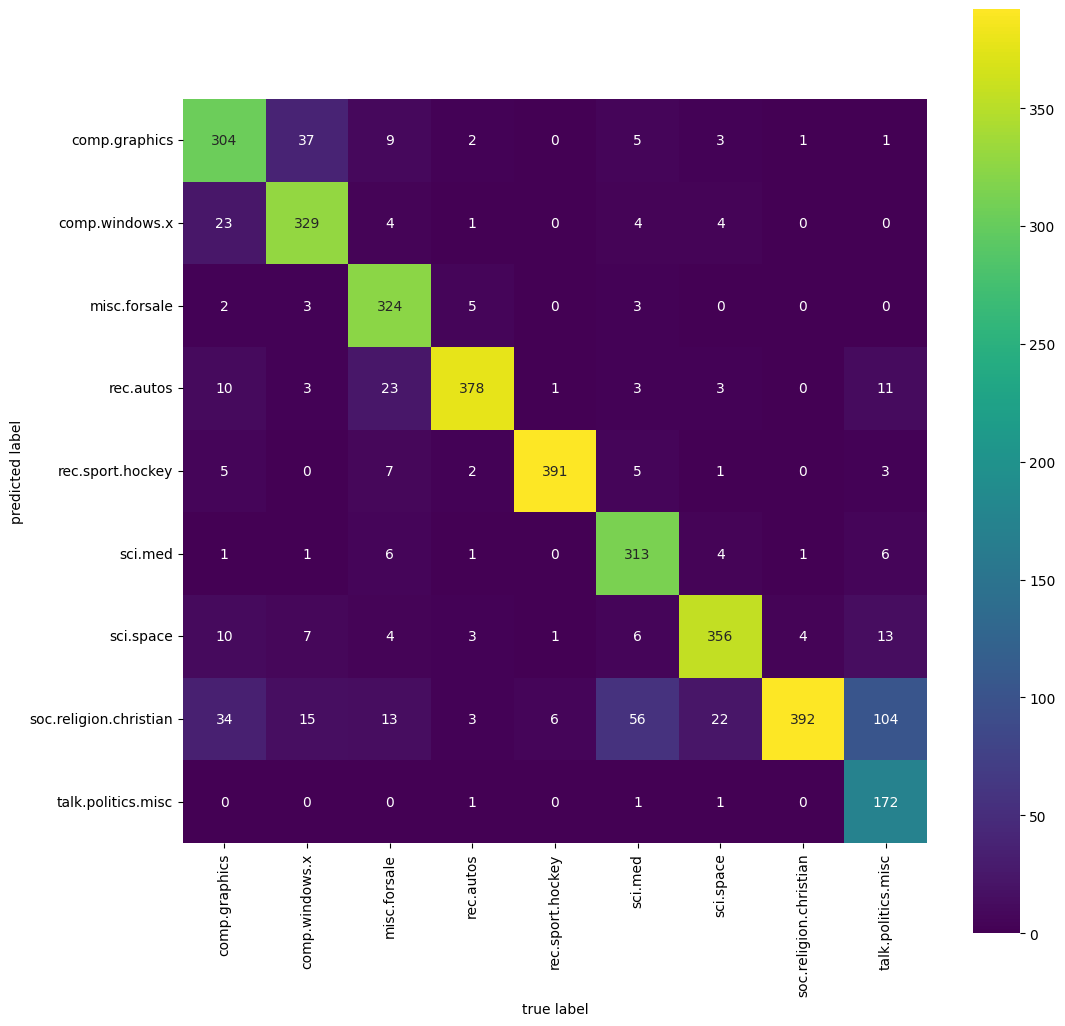

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(test.target, labels)
fig = plt.figure(figsize=(12, 12))
ax = sns.heatmap(
    mat.T,
    square=True,
    annot=True,
    fmt="d",
    cmap="viridis",
    xticklabels=train.target_names,
    yticklabels=train.target_names,
)
ax.set_xlabel("true label")
ax.set_ylabel("predicted label");

The worst result is across *religion* and *politics*.
No surprises there, these topics get intermingled in the real world too.

That said, with a very simple classifier and some data encoding we have built
a model that can tell us the topic of a sentence.
We can see it in action with a small helper function:

In [11]:
def predict_chat(sentence: str):
    predicted = model.predict([sentence])
    return train.target_names[predicted[0]]

print(
    "TUNING",
    predict_chat("I've added a new set of cyllinders, now I'm not even making 10 miles per galon"),
)
print("BALL", predict_chat("The ball never went even close to the goal"))
print("BUTTON", predict_chat("Dude, I'm telling you, there is no such button on my screen"))
print("WIFE", predict_chat("My wife went shopping in the morning, has not come back yet"))
print("PRESCRIPTION", predict_chat("Got my prescription rejected at the pharmacy"))
print("APOLLO", predict_chat("No one ever landed on the moon, it was all a farse"))

TUNING rec.autos
BALL rec.sport.hockey
BUTTON comp.windows.x
WIFE soc.religion.christian
PRESCRIPTION sci.med
APOLLO sci.space


Given that all this is doing is checking the word frequency probabilities,
this is a rather amazing result for a such a simple algorithm.

And we can still see the problems with *religion* and *politics* in the predictions.
This problem happens because these two topics use lots of *stop words*,
i.e. words that are commonly used in sentence construction.
For example:

In [12]:
predict_chat("the what where")

'soc.religion.christian'

If we remove the stop words from the data representation we should
get a better separation between religion and politics.

Stop words are most common words, including conjunctions and other sentence building blocks.
We have a file called `stopwords-en.txt` which we can load.

In [13]:
filename = "fe-stopwords-en.txt"
with open(filename) as f:
    stopwords = [l.strip() for l in f]
stopwords[:10]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost']

If we repeat the pipeline we should get a better result now.

In [14]:
model = make_pipeline(TfidfVectorizer(stop_words=stopwords), MultinomialNB())
model.fit(train.data, train.target)
labels = model.predict(test.data)

And we should look at the plot for improvements.

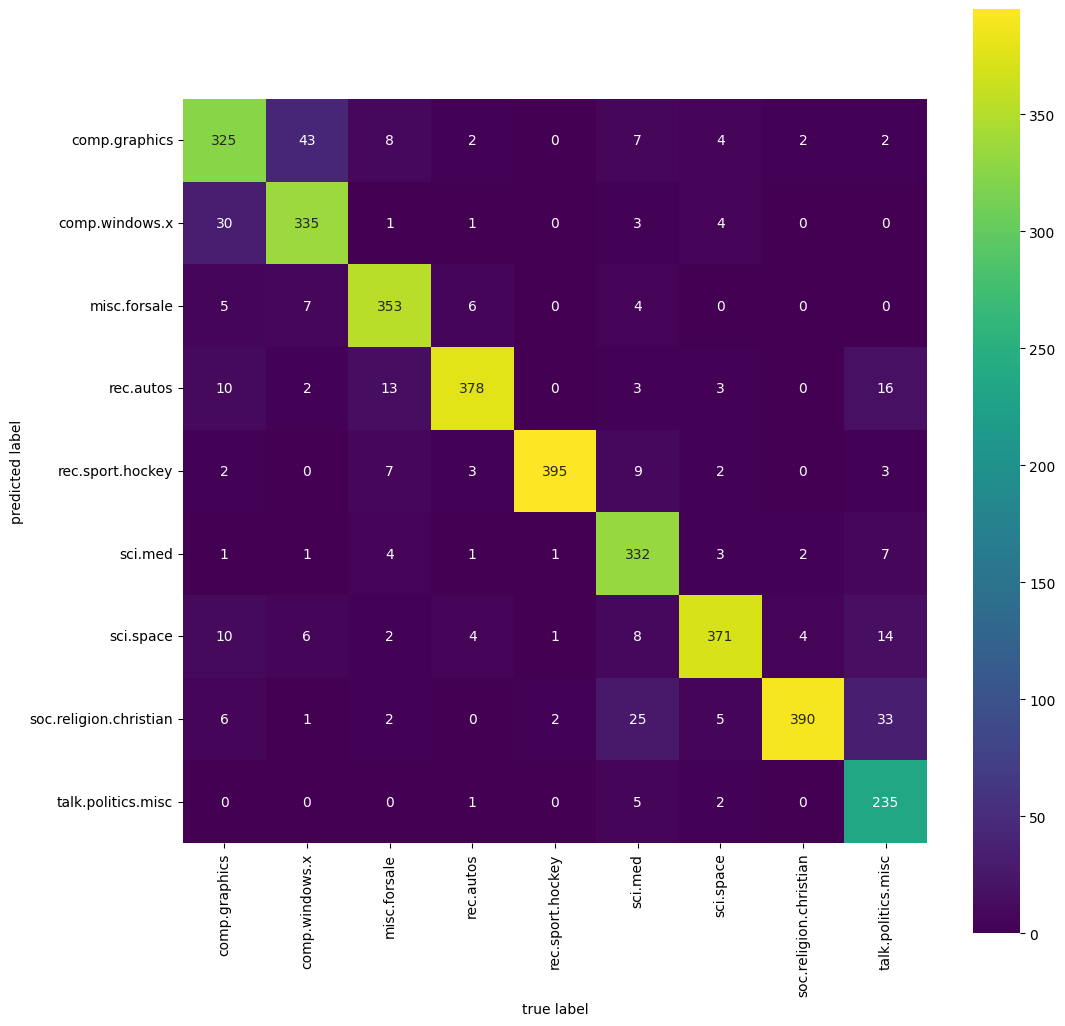

In [15]:
mat = confusion_matrix(test.target, labels)
fig = plt.figure(figsize=(12, 12))
ax = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap='viridis',
                 xticklabels=train.target_names, yticklabels=train.target_names)
ax.set_xlabel('true label')
ax.set_ylabel('predicted label');

We managed to remove some of the confusion between religion and politics.
Wish it would be that easy in real life.
Also the general shape of the graphs is better,
with a more prominent diagonal.

## References

- [Term frequency and weighting - Introduction to Information Retrieval][1]
- [Weighting Schemes - Introduction to Information Retrieval][2]

[1]: https://nlp.stanford.edu/IR-book/html/htmledition/term-frequency-and-weighting-1.html "TF-IDF"
[2]: https://nlp.stanford.edu/IR-book/html/htmledition/document-and-query-weighting-schemes-1.html "weighting"